In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import emcee
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
from models_EF import *

In [3]:
E,flux,e_up,e_down = np.loadtxt('data_error_68-2.txt',unpack=True)

In [4]:
error = e_up**2 + e_down**2

In [5]:
p_list = [-0.4 ,2., 2.,4.,-20.,2.]
bnds = ((-0.4,2.), (2.,4.), (-20.,2.))
mid = [1.,3.,-5.]

In [6]:
pars_test = [0.7,np.log10(1200.),-14.]

In [7]:
fun = lambda *args: -flux_lnhood(*args)

In [8]:
import scipy.optimize as op

In [9]:
result = op.minimize(fun, mid, args=(flux,error,E,'pulsar',None), 
                     method = 'TNC',bounds=bnds)

In [10]:
print result.x

[ -0.34596398   3.39732582 -12.31289048]


In [11]:
init_model = Flux(E,model_i='pulsar')
model_infer  = init_model(result.x)

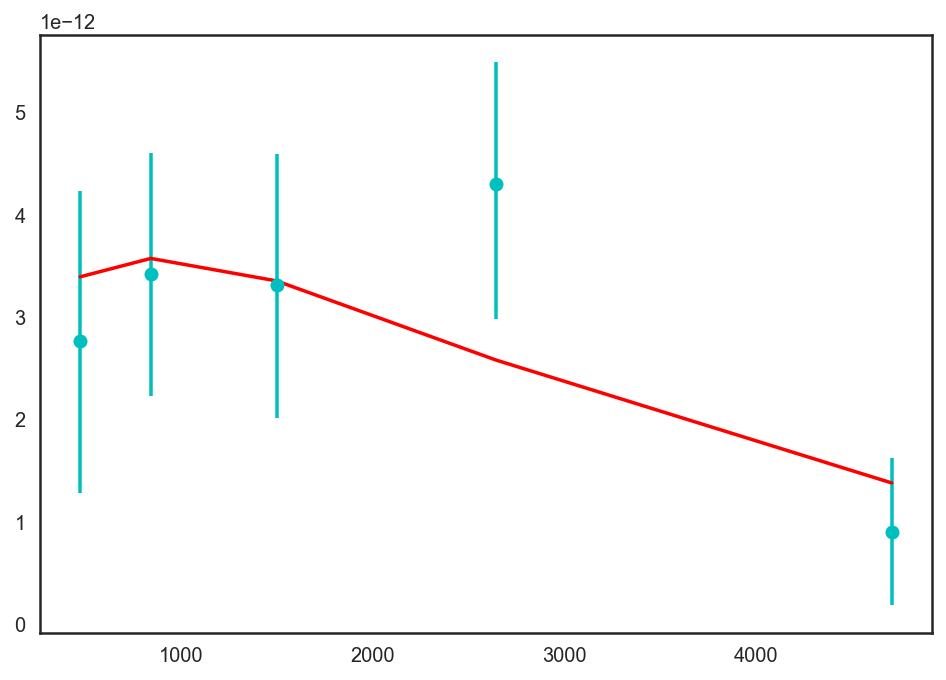

In [12]:
plt.plot(E,model_infer,'r');
plt.errorbar(E,flux,[e_up,e_down],fmt='o',color='c');

In [13]:
#no_events = np.loadtxt('no_events.dat')
e1_test,e2_test = np.loadtxt('Energies.dat',unpack=True).T

In [14]:
#no_events = no_events[1:]

In [15]:
#print no_events

In [16]:
Ener,no_events,el,er = np.loadtxt('data_events.txt',unpack=True)

In [17]:
print no_events

[189. 166. 171. 125.  24.]


In [18]:
e_min = Ener - el
e_max = Ener + er

In [19]:
print e_min
print e_max

[ 200.          437.34484863  956.35247803 2091.27905273 4573.05029297]
[  437.34484863   956.35247803  2091.27905273  4573.05029297
 10000.        ]


In [20]:
print e1_test
print e2_test

[ 200.          355.42538452  631.63592529 1122.49719238 1994.81982422
 3545.0480957 ]
[ 355.42538452  631.63592529 1122.49719238 1994.81982422 3545.0480957
 6300.        ]


In [21]:
print len(flux)

5


In [22]:
like_test = event_lnhood(pars_test,no_events,e_min,e_max,'pulsar',None,None,None)

In [23]:
print like_test

-24047.399095861147


In [24]:
print no_events

[189. 166. 171. 125.  24.]


In [25]:
fun2 = lambda *args: -event_lnhood(*args)

In [26]:
result2 = op.minimize(fun2, mid, args=(no_events,e_min,e_max,'pulsar',None,None,None), 
                     method = 'L-BFGS-B')

In [27]:
print result2.x

[0.68759227 3.36103799 1.63320829]


In [28]:
p_list_2 = [-0.4 ,2., 2.,4.,-3.,3.]
bnds_2 = ((-0.4,2.), (2.,4.), (-3.,3.))
mid_2 = [1.,3.,-1.]

In [29]:
nwalkers = 60
ndim = len(p_list_2)/2

In [30]:
z = np.zeros((ndim,nwalkers))

In [31]:
h = 1e-2

pos_i=[]


for i in range(ndim):
    z[i,:] = mid_2[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i]]))

In [32]:
b_steps, steps = 500, 1500

In [33]:
sampler = emcee.EnsembleSampler(nwalkers, ndim,event_lnpost, 
                                args=(no_events,e_min,e_max,'pulsar',p_list_2,None,None,None),
                                threads = 2)

In [34]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [35]:
print sampler.acceptance_fraction.mean()

0.5833666666666666


In [36]:
sampler.reset()

In [37]:
_,_,_=sampler.run_mcmc(pos, steps, rstate0=state)

In [38]:
print sampler.acceptance_fraction.mean()

0.6441222222222222


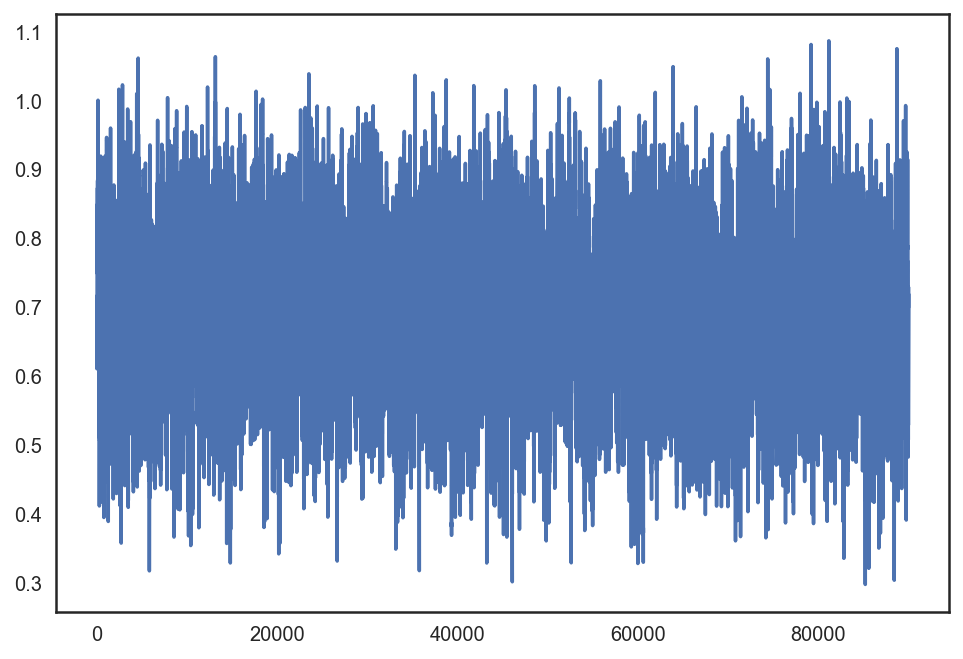

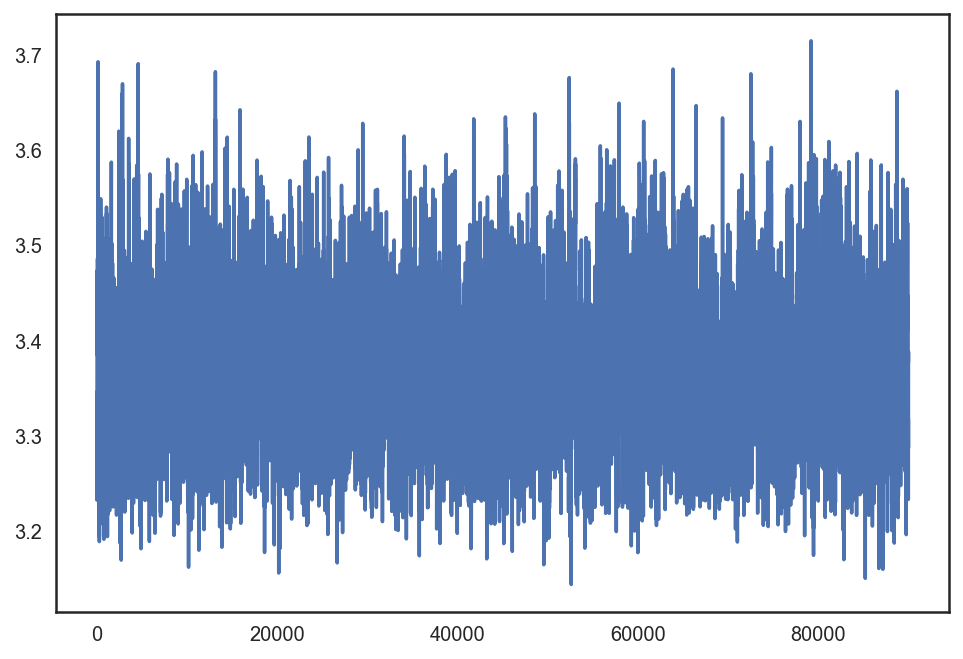

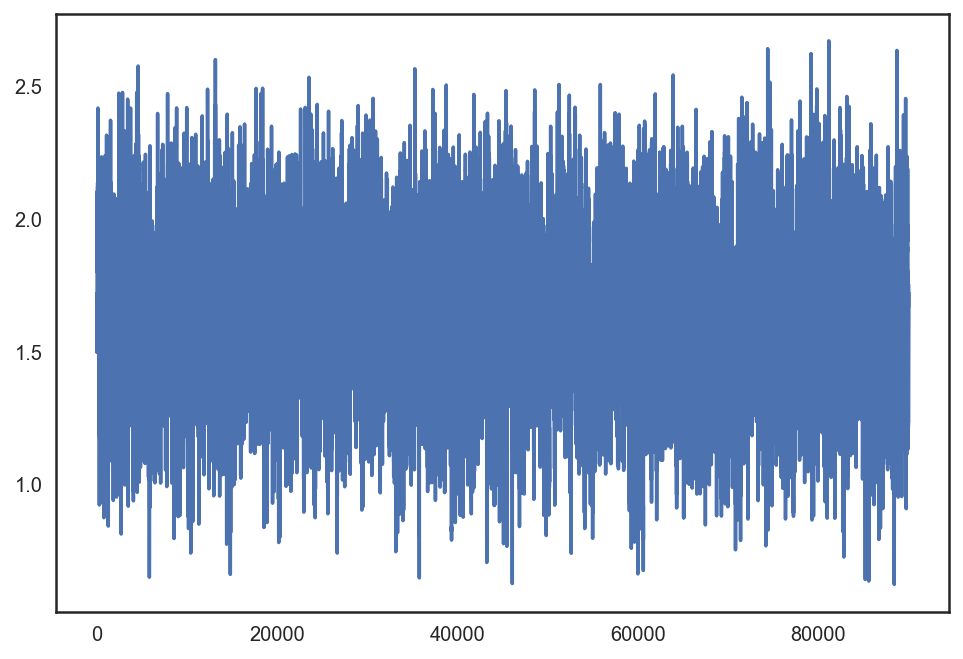

In [39]:
plt.figure()
plt.plot(sampler.flatchain[:,0]);
plt.figure()
plt.plot(sampler.flatchain[:,1]);
plt.figure()
plt.plot(sampler.flatchain[:,2]);

In [40]:
import corner as corner 

In [41]:
labels = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)']

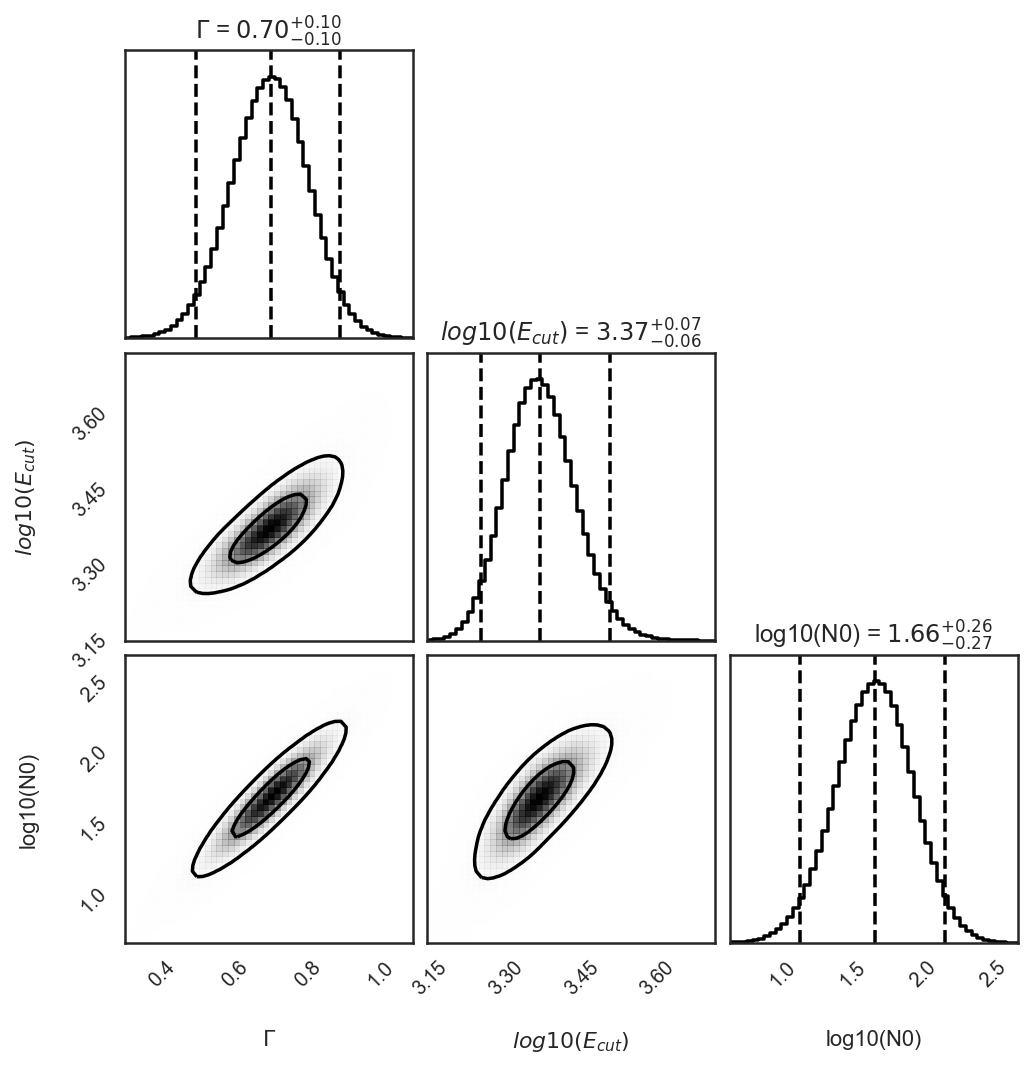

In [42]:
fig = corner.corner(sampler.flatchain,bins=50,labels=labels,plot_datapoints=False,smooth=2., 
                    smooth1d=2.,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [43]:
fig.savefig('data_wo_background_events.pdf')

In [44]:
events = no_events_model_pulsar([0.7,np.log10(2500.),1.4],e_min,e_max)

In [45]:
print events

[ 96.0220154  105.05946115  97.15344341  63.02214661  19.92431838]


In [46]:
10.**3.37

2344.228815319923

In [47]:
np.savetxt('chains_events_wob.dat',sampler.flatchain)

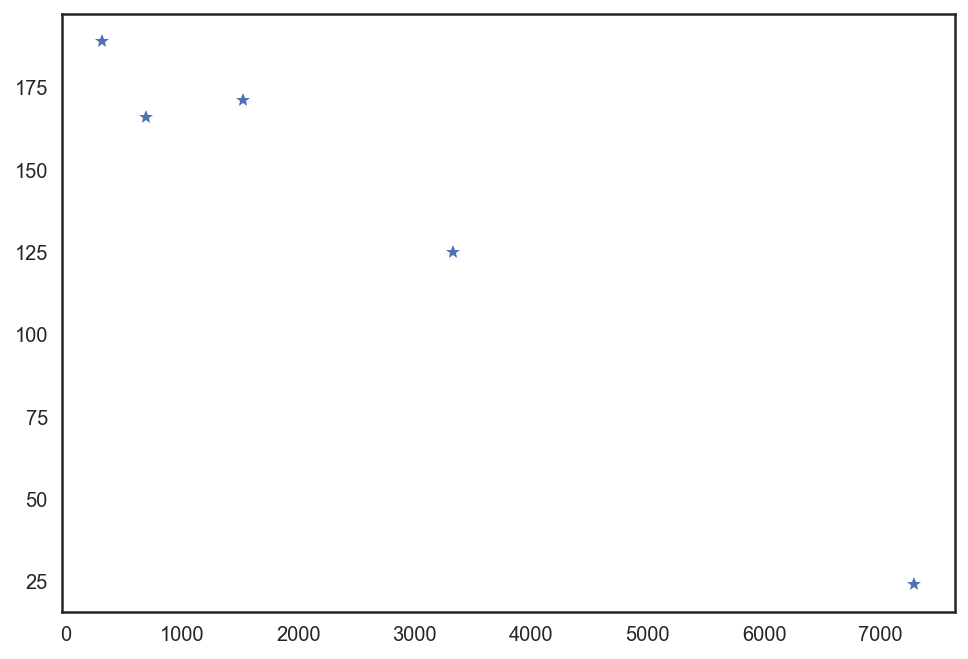

In [48]:
plt.plot(Ener,no_events,'*');

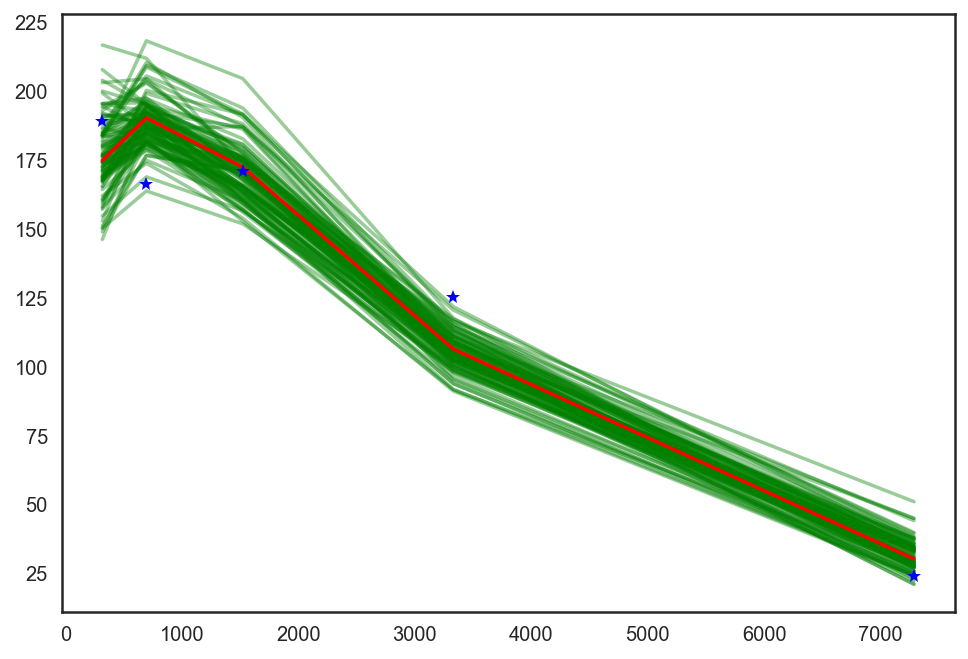

In [50]:
for c1,c2,c3 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    plt.plot(Ener,no_events_model_pulsar([c1,c2,c3],e_min,e_max),'g',alpha=0.4);

plt.plot(Ener,no_events_model_pulsar([0.69,3.36,1.64],e_min,e_max),'r');
plt.plot(Ener,no_events,'*b');